In [12]:
import argparse
import os
from zipfile import ZipFile
from urllib.request import urlopen
import shutil
import pandas as pd
from time import time
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.optimizers import Adam
import csv
from keras.models import Model, load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K
from skimage.io import imread
from skimage.transform import resize
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
import requests
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt



# Global paths
OUTPUT_DIRECTORY = "./outputs/"
LABEL_DIRECTORY = "./drive/MyDrive/Colab Notebooks/labels/"
MODEL_DIRECTORY = "./models/"
MODEL_GD_ID = "1MRbN5hXOTYnw7-71K-2vjY01uJ9GkQM5"
MODEL_ZIP_FILE = "./models/models.zip"
IMG_DIRECTORY = "./images/"
IMG_GD_ID = "1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj"
IMG_ZIP_FILE = "./images/images.zip"

# Global variables
RAW_IMG_SIZE = (256, 256)
IMG_SIZE = (224, 224)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 100
BATCH_SIZE =32
#FOLDS = 5
STOPPING_PATIENCE = 32
LR_PATIENCE = 16
INITIAL_LR = 0.0001
CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]

CLASS_NAMES = ['Chinee Apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly Acacia',
               'Rubber Vine',
               'Siam Weed',
               'Snake Weed',
               'Negatives']


def download_google_drive_file(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


def parse_args():
    parser = argparse.ArgumentParser(description='Train and test ResNet50, InceptionV3, or custom model on DeepWeeds.')
    parser.add_argument("command", default='train', help="'cross_validate' or 'inference'")
    parser.add_argument('--model', default='resnet', help="'resnet', 'inception', or path to .hdf5 file.")
    args = parser.parse_args()
    return args.command, args.model


def download_images():
    if not os.path.exists(IMG_DIRECTORY):
        os.makedirs(IMG_DIRECTORY)
        print("Downloading DeepWeeds images to " + IMG_ZIP_FILE)
        download_google_drive_file(IMG_GD_ID, IMG_ZIP_FILE)
        print("Finished downloading images.")
        print("Unzipping " + IMG_ZIP_FILE)
        with ZipFile(IMG_ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(IMG_DIRECTORY)
        print("Finished unzipping images.")


def download_models():
    if not os.path.exists(MODEL_DIRECTORY):
        os.makedirs(MODEL_DIRECTORY)
        print("Downloading DeepWeeds models to " + MODEL_ZIP_FILE)
        download_google_drive_file(MODEL_GD_ID, MODEL_ZIP_FILE)
        print("Finished downloading models.")
        print("Unzipping " + MODEL_ZIP_FILE)
        with ZipFile(MODEL_ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(MODEL_DIRECTORY)
        print("Finished unzipping models.")


def crop(img, size):
    """
    Crop the image concentrically to the desired size.
    :param img: Input image
    :param size: Required crop image size
    :return:
    """
    (h, w, c) = img.shape
    x = int((w - size[0]) / 2)
    y = int((h - size[1]) / 2)
    return img[y:(y + size[1]), x:(x + size[0]), :]


def crop_generator(batches, size):
    """
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    :param batches: Batches of images to be cropped
    :param size: Size to be cropped to
    :return:
    """
    while True:
        batch_x, batch_y = next(batches)
        (b, h, w, c) = batch_x.shape
        batch_crops = np.zeros((b, size[0], size[1], c))
        for i in range(b):
            batch_crops[i] = crop(batch_x[i], (size[0], size[1]))
        yield (batch_crops, batch_y)






download_images()
download_models()





k = 1
timestamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
#print('Fold {}/{} - {}'.format(k + 1, FOLDS, timestamp))
output_directory = "{}{}/".format(OUTPUT_DIRECTORY, timestamp)
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


train_label_file = "{}train_subset{}.csv".format(LABEL_DIRECTORY, k)
val_label_file = "{}val_subset{}.csv".format(LABEL_DIRECTORY, k)
test_label_file = "{}test_subset{}.csv".format(LABEL_DIRECTORY, k)
train_dataframe = pd.read_csv(train_label_file)
val_dataframe = pd.read_csv(val_label_file)
test_dataframe = pd.read_csv(test_label_file)
train_dataframe = train_dataframe.astype(str)
val_dataframe = val_dataframe.astype(str)
test_dataframe = test_dataframe.astype(str)
train_image_count = train_dataframe.shape[0]
val_image_count = train_dataframe.shape[0]
test_image_count = test_dataframe.shape[0]

# Training image augmentation
train_data_generator = ImageDataGenerator(
    rescale=1. / 255,
    fill_mode="constant",
    shear_range=0.2,
    zoom_range=(0.5, 1),
    horizontal_flip=True,
    channel_shift_range=25,
    brightness_range=(0.75, 1.25))

# Validation image augmentation
val_data_generator = ImageDataGenerator(
    rescale=1. / 255,
    fill_mode="constant",
    shear_range=0.2,
    zoom_range=(0.5, 1),
    horizontal_flip=True,
    rotation_range=360,
    channel_shift_range=25,
    brightness_range=(0.75, 1.25))

# No testing image augmentation (except for converting pixel values to floats)
test_data_generator = ImageDataGenerator(rescale=1. / 255)

# Load train images in batches from directory and apply augmentations
train_data_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_dataframe,
    directory=IMG_DIRECTORY,
    x_col='Filename',
    y_col='Label',
    target_size=RAW_IMG_SIZE,
    batch_size=BATCH_SIZE,
    has_ext=True,
    classes=CLASSES,
    class_mode='categorical')

# Load validation images in batches from directory and apply rescaling
val_data_generator = val_data_generator.flow_from_dataframe(
    dataframe=val_dataframe,
    directory=IMG_DIRECTORY,
    x_col="Filename",
    y_col="Label",
    target_size=RAW_IMG_SIZE,
    batch_size=BATCH_SIZE,
    has_ext=True,
    classes=CLASSES,
    class_mode='categorical')

# Load test images in batches from directory and apply rescaling
test_data_generator = test_data_generator.flow_from_dataframe(
    dataframe=test_dataframe,
    directory=IMG_DIRECTORY,
    x_col="Filename",
    y_col="Label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    has_ext=True,
    shuffle=False,
    classes=CLASSES,
    class_mode='categorical')

# Crop augmented images from 256x256 to 224x224
train_data_generator = crop_generator(train_data_generator, IMG_SIZE)
val_data_generator = crop_generator(val_data_generator, IMG_SIZE)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(224,224,3,)))
# Input layer
# Can be omitted, you can specify the input_shape in other layers
# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
model.add(tf.keras.layers.Dense(9, activation='softmax'))






early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, restore_best_weights=True)
tensorboard = TensorBoard(log_dir=output_directory, histogram_freq=0, write_graph=True, write_images=False)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=LR_PATIENCE, min_lr=0.000003125)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=INITIAL_LR), metrics=['categorical_accuracy'])
csv_logger = CSVLogger(output_directory + "training_metrics.csv")

checkpoint = tf.keras.callbacks.ModelCheckpoint(output_directory + "lastbest-0.hdf5", #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_categorical_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)


model.summary()

history = model.fit(train_data_generator,
            steps_per_epoch=train_image_count // BATCH_SIZE,
            epochs=MAX_EPOCH,
            validation_data=val_data_generator,
            validation_steps=val_image_count  // BATCH_SIZE,
            callbacks=[checkpoint],
            verbose = 1,
            shuffle=False)




--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 10504 validated image filenames belonging to 9 classes.
Found 3502 validated image filenames belonging to 9 classes.
Found 3503 validated image filenames belonging to 9 classes.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 111, 111, 64)      256       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
b

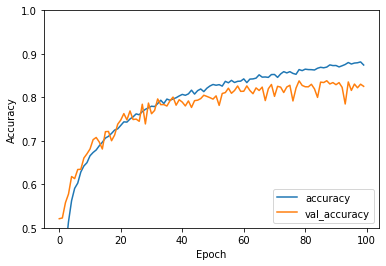

In [13]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [14]:
plt.savefig("/content/drive/MyDrive/Colab Notebooks/h5/cnn.png")

<Figure size 432x288 with 0 Axes>

In [15]:
test_loss, test_acc = model.evaluate(test_data_generator, verbose=1)
print(test_acc)

110/110 [==============================] - 10s 86ms/step - loss: 0.1161 - categorical_accuracy: 0.7933
0.7933200001716614


In [17]:
 # Load the last best model


# Evaluate model on test subset for kth fold
predictions = model.predict(test_data_generator, test_image_count // BATCH_SIZE + 1)


y_true = test_data_generator.classes
y_pred = np.argmax(predictions, axis=1)
y_pred[np.max(predictions, axis=1) < 1 / 9] = 8  # Assign predictions worse than random guess to negative class

y_true = [str(int) for int in y_true]
y_pred = np.array([str(i).split('.')[0] for i in y_pred])

# Generate and print classification metrics and confusion matrix
print(classification_report(y_true, y_pred, labels=CLASSES, target_names=CLASS_NAMES))
report = classification_report(y_true, y_pred, labels=CLASSES, target_names=CLASS_NAMES, output_dict=True)
with open(output_directory + 'classification_report.csv', 'w') as f:
    for key in report.keys():
        f.write("%s,%s\n" % (key, report[key]))
conf_arr = confusion_matrix(y_true, y_pred, labels=CLASSES)
print(conf_arr)
np.savetxt(output_directory + "confusion_matrix.csv", conf_arr, delimiter=",")



                precision    recall  f1-score   support

  Chinee Apple       0.67      0.62      0.64       225
       Lantana       0.66      0.75      0.70       213
   Parkinsonia       0.96      0.73      0.83       206
    Parthenium       0.66      0.79      0.72       205
Prickly Acacia       0.82      0.82      0.82       213
   Rubber Vine       0.91      0.77      0.83       202
     Siam Weed       0.91      0.67      0.77       215
    Snake Weed       0.39      0.81      0.52       203
     Negatives       0.91      0.84      0.87      1821

      accuracy                           0.79      3503
     macro avg       0.77      0.75      0.75      3503
  weighted avg       0.83      0.79      0.80      3503

[[ 139    5    0    9    0    0    3   56   13]
 [   5  159    0    6    0    0    2   24   17]
 [   4    0  150    4   11    0    0   16   21]
 [   0    5    0  162    9    0    0   13   16]
 [   1    0    1   12  174    0    0   14   11]
 [   4    8    0    1    0  1